In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

In [2]:
import os
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import LogGaussMF


def train_model():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, 3, strides=1, activation="relu", padding="same"),
        layers.Flatten(),
        LogGaussMF(10),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))),
        layers.Dense(10),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.0005),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)

    return model


if not os.path.exists("saved_models/"):
    os.makedirs("saved_models/")
    
if not os.path.exists("saved_models/rp_conv1_model.h5"):
    model = train_model()
    model.save("saved_models/rp_conv1_model.h5")
else:
    print("Loading saved model...", end=" ")
    model = keras.models.load_model(
    "saved_models/rp_conv1_model.h5",
    custom_objects={
        "LogGaussMF": lambda **x: LogGaussMF(rules=10, **x),
    })
    print("done.")

Using TensorFlow backend.


Loading saved model... 

W0401 15:03:11.873835 140507688253248 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


done.


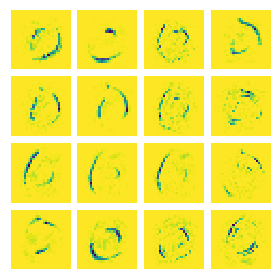

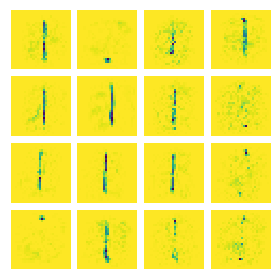

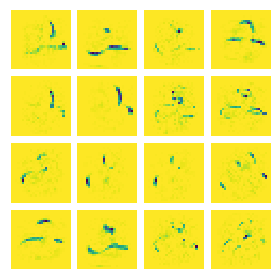

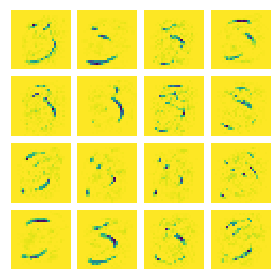

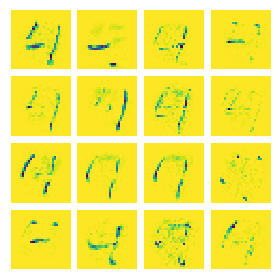

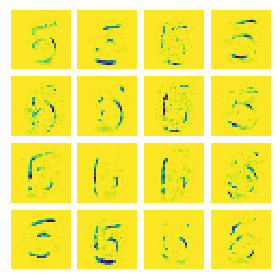

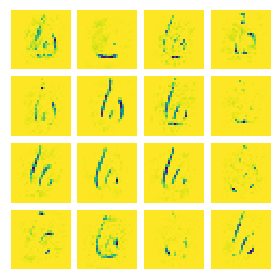

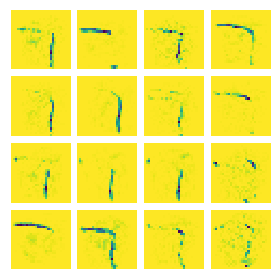

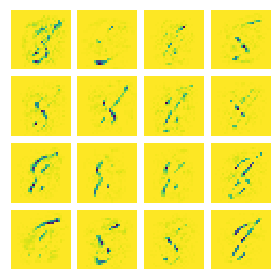

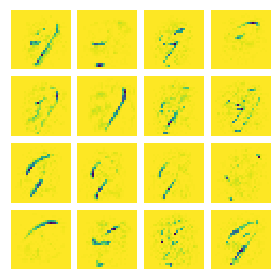

In [6]:
import innvestigate
from keras.models import Model


def plot_membership(model, representative):
    assert(isinstance(model.layers[-6], layers.Flatten))
    assert(isinstance(model.layers[-5], LogGaussMF))
    assert(isinstance(model.layers[-4], layers.Lambda))
    assert(isinstance(model.layers[-3], layers.Lambda))
    assert(isinstance(model.layers[-2], layers.Dense))
    
    # outputs needed for analyzing the network
    features_tensor = model.layers[-6].output
    membership_tensor = model.layers[-5].output
    firing_strength_tensor = model.layers[-3].output
    logits_tensor = model.layers[-2].output
    
    # new model with the outputs from above
    analysis_model = Model(model.inputs, [
        features_tensor,
        membership_tensor,
        firing_strength_tensor,
        logits_tensor,
    ])
    
    # compute the values of those tensors on the representative
    features, log_membership, firing_strength, logits = analysis_model.predict(
        representative.reshape(1, 28, 28))
    
    # find and output the max logit
    logit_val, logit_idx = np.max(logits), np.argmax(logits)
    
    # find the rule that contributed most to the logit
    # this is computed as firing strength multiplied by the weights
    W = analysis_model.layers[-1].get_weights()[0]
    R = W[:,logit_idx] * firing_strength
    rule_val, rule_idx = np.max(R), np.argmax(R)
    
    mu, beta = analysis_model.layers[-4].get_weights()
    membership = np.exp(log_membership[:,rule_idx,:]).reshape(28, 28, 16)
    
    fig, axes = plt.subplots(4, 4, figsize=(4,4))
    axes = axes.flatten()
    for i in range(16):
        axes[i].imshow(membership[:,:,i])
    
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
    
    
medoids = [26438, 54614, 1299, 42186, 56856, 57814, 44801, 53334, 15115, 24825]

for medoid in medoids:
    plot_membership(model, train_x[medoid])